# **Economic Development vs. Sustainability**
# Data Cleaning - GDP
Katlyn Goeujon-Mackness <br>
Last Updated: 18/06/2025

## Table of Contents

**1. Introduction**
- Purpose of the Notebook
- Overview of GDP Data Sources

**2. Loading and Inspecting Data**
- Importing GDP datasets
- Checking structure and missing values
- Summary statistics and initial observations

**3. Handling Missing Values**
- Identifying missing data patterns
- Forward and backward filling strategies
- Interpolation techniques

**4. Outlier Detection & Treatment**
- Boxplot analysis of GDPAnnualPercent & GDPConstantUSD
- Winsorizing extreme GDP growth values
- Log transformation for GDPConstantUSD

**5. Feature Engineering & Transformation**
- Creating winsorized GDP columns
- Storing transformed vs original values
- Verifying distributions after transformations

**6. Preparing Data for CO_2 Analysis**
- Ensuring GDP alignment with emissions datasets
- Checking correlations and relationships
- Standardization and final dataset structuring

## Introduction

Economic growth is often pursued at the cost of environmental sustainability. This study aims to analyze the balance between economic development and sustainable practices across different regions, industries, and policies.

In this **data cleaning phase**, we will refine and structure the dataset by handling missing values, removing redundant entries, and ensuring consistency in country classifications and ISO codes. This process will improve data quality, enabling accurate analysis. Once cleaned, we will export the processed dataset in CSV format for further exploration.

### Key Challenge
Achieving sustainable economic growth requires balancing financial prosperity with environmental and social responsibility. Identifying actionable patterns in historical data can inform policymakers, businesses, and environmental advocates.

### Data of Interest
- GDP growth rate compared to carbon emissions per capita (current analysis).
- Percentage of renewable energy adoption.
- Employment trends in green industries.
- Improvement in environmental quality indicators (air quality, water safety).
- Sustainability index scores vs. economic performance.

### Locating Relevant Data
- **World Bank**: Economic indicators.
    * [GDP per capita growth (annual %)](https://data.worldbank.org/indicator/NY.GDP.PCAP.KD.ZG)
    * [GDP per capita (constant 2015 US$)](https://data.worldbank.org/indicator/NY.GDP.PCAP.KD)
- **Our World in Data**: Environmental indicators and population data
    * [CO2 and Greenhouse Gas Emissions](https://github.com/owid/co2-data)
    * [Historical and Projected Population](https://ourworldindata.org/population-sources) 
- **United Nations SDGs Database**: Sustainable development statistics.
- **OECD**: Policy effectiveness on sustainability.
- **NASA Earth Observations**: Environmental impact metrics.
- **National Employment Data**: Job growth in sustainable sectors.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

# Prevent truncating columns and rows
pd.set_option("display.max_rows", None) 
pd.set_option("display.max_columns", None) 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# List of countries and country codes
countries = pd.read_csv("../data/in_process/1a_gdp_countries_structured.csv")

# List of regions and income groups with their country codes
region_groups = pd.read_csv("../data/in_process/1b_co2_region_groups_structured.csv")

# GDP data based on world regions and economic groups
gdp_by_groups = pd.read_csv("../data/in_process/1a_gdp_by_groups_structured.csv")

# GDP data based on country
gdp_by_country = pd.read_csv("../data/in_process/1a_gdp_by_country_structured.csv")

In [5]:
# Make sure datasets are loaded properly
countries.head(3)

,Country Name,Country Code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA


In [6]:
region_groups.head(3)

,Unnamed: 0,Region Group Name,Country Code
0,0,Africa Eastern and Southern,AFE
1,1,Africa Western and Central,AFW
2,2,Arab World,ARB


In [7]:
gdp_by_groups.head(3)

,Country Code,Region Group Name,Year,GDPAnnualPercent,GDPConstantUSD
0,AFE,Africa Eastern and Southern,1960,NaN,1172.316285
1,AFE,Africa Eastern and Southern,1961,-2.136630,1147.268217
2,AFE,Africa Eastern and Southern,1962,5.009835,1204.744460


In [8]:
gdp_by_country.head(3)

,Country Name,Country Code,Year,GDPAnnualPercent,GDPConstantUSD
0,Afghanistan,AFG,1960,NaN,NaN
1,Afghanistan,AFG,1961,NaN,NaN
2,Afghanistan,AFG,1962,NaN,NaN


---

## Countries Dataset
### Missing Data
No Data is Missing

In [9]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  218 non-null    object
 1   Country Code  218 non-null    object
dtypes: object(2)
memory usage: 3.5+ KB


### Duplicate Data
No Duplicate Data Found

In [10]:
duplicates = countries[countries.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Country Name, Country Code]
Index: []


---

## Regions and Economic Grouping Dataset
### Missing Data
No missing data found.

In [11]:
region_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         61 non-null     int64 
 1   Region Group Name  61 non-null     object
 2   Country Code       61 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
# Remove extraneous index column
region_groups = region_groups.drop(columns=["Unnamed: 0"])

# Verify removal
region_groups.head(3)

,Region Group Name,Country Code
0,Africa Eastern and Southern,AFE
1,Africa Western and Central,AFW
2,Arab World,ARB


### Duplicate Data
No duplicate data found.

In [13]:
duplicates = region_groups[countries.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Region Group Name, Country Code]
Index: []


---

## GDP by Regions and Economic Groupings Dataset
### Missing Data

In [14]:
gdp_by_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Code       3072 non-null   object 
 1   Region Group Name  3072 non-null   object 
 2   Year               3072 non-null   int64  
 3   GDPAnnualPercent   2884 non-null   float64
 4   GDPConstantUSD     2932 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 120.1+ KB


In [15]:
# Missing data found - check how many exactly
print(gdp_by_groups.isnull().sum())

Country Code           0
Region Group Name      0
Year                   0
GDPAnnualPercent     188
GDPConstantUSD       140
dtype: int64


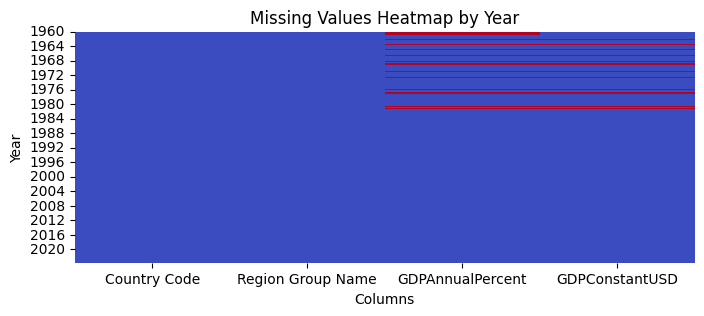

In [16]:
# Set 'Year' as index for correct y-axis labeling
gdp_by_groups_by_year = gdp_by_groups.sort_values("Year").set_index("Year")

# Plot missing values heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(gdp_by_groups_by_year.isna(), cmap="coolwarm", cbar=False)

plt.title("Missing Values Heatmap by Year")
plt.xlabel("Columns")
plt.ylabel("Year")
plt.show()

#### Handle Missing Values
Missing records are before 1985. We will use forward fill to handle these missing values.

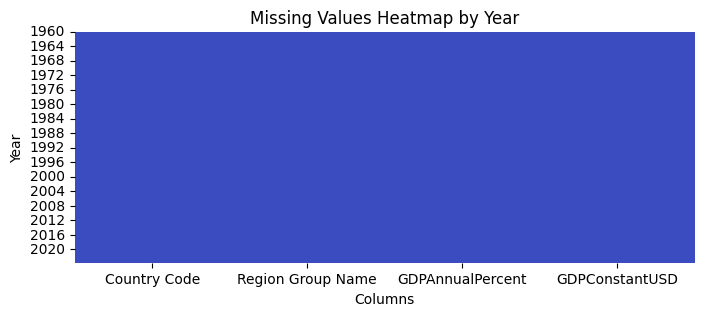

In [17]:
# Group by Country Code and apply forward within each group
gdp_by_groups[["GDPAnnualPercent", "GDPConstantUSD"]] = (
    gdp_by_groups.groupby("Country Code")[["GDPAnnualPercent", "GDPConstantUSD"]].ffill()
)

# Group by Country Code and apply backfill to fill the remaining gaps
gdp_by_groups[["GDPAnnualPercent", "GDPConstantUSD"]] = (
    gdp_by_groups.groupby("Country Code")[["GDPAnnualPercent", "GDPConstantUSD"]].bfill()
)


# Visually verify changes
# Set 'Year' as index for correct y-axis labeling
gdp_by_groups_by_year = gdp_by_groups.sort_values("Year").set_index("Year")

# Plot missing values heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(gdp_by_groups_by_year.isna(), cmap="coolwarm", cbar=False)

plt.title("Missing Values Heatmap by Year")
plt.xlabel("Columns")
plt.ylabel("Year")
plt.show()

### Duplicated Data
No duplicate data found

In [18]:
duplicates = gdp_by_groups[gdp_by_groups.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Country Code, Region Group Name, Year, GDPAnnualPercent, GDPConstantUSD]
Index: []


### Outliers
Given wide range and high standard deviation, this dataset shows potential outliers.

In [19]:
gdp_by_groups.describe()

,Year,GDPAnnualPercent,GDPConstantUSD
count,3072.000000,3072.000000,3072.000000
mean,1991.500000,1.915004,6642.774408
std,18.475961,3.554818,9493.820156
min,1960.000000,-13.286964,274.595307
25%,1975.750000,0.243514,1249.953273
50%,1991.500000,2.109874,2888.854832
75%,2007.250000,3.788082,6977.519630
max,2023.000000,22.285694,63594.398681


#### Z-score testing
Significant extreme outliers detected in the data.

In [20]:
# Compute z-scores
gdp_by_groups["GDPAnnualPercent_Z"] = zscore(gdp_by_groups["GDPAnnualPercent"])
gdp_by_groups["GDPConstantUSD_Z"] = zscore(gdp_by_groups["GDPConstantUSD"])

# Identify potential outliers (z-score > 3 or <-3)
outliers = gdp_by_groups[
    (gdp_by_groups["GDPAnnualPercent_Z"].abs() > 3) |
    (gdp_by_groups["GDPConstantUSD_Z"].abs() > 3)
]
outliers.head()

,Country Code,Region Group Name,Year,GDPAnnualPercent,GDPConstantUSD,GDPAnnualPercent_Z,GDPConstantUSD_Z
71,AFW,Africa Western and Central,1967,-11.080289,1060.095104,-3.656279,-0.588129
74,AFW,Africa Western and Central,1970,14.733574,1358.785939,3.606558,-0.556662
85,AFW,Africa Western and Central,1981,-9.364999,1436.929034,-3.173675,-0.548430
87,AFW,Africa Western and Central,1983,-8.863464,1230.695048,-3.032566,-0.570156
138,ARB,Arab World,1970,19.274519,3319.012494,4.884171,-0.350154


In [21]:
outliers.tail()

,Country Code,Region Group Name,Year,GDPAnnualPercent,GDPConstantUSD,GDPAnnualPercent_Z,GDPConstantUSD_Z
2303,PST,Post-demographic dividend,2023,1.704510,46030.095565,-0.059223,4.149408
2560,TEA,East Asia & Pacific (IDA & IBRD),1960,-13.260177,327.135944,-4.269600,-0.665345
2561,TEA,East Asia & Pacific (IDA & IBRD),1961,-13.260177,283.757140,-4.269600,-0.669915
2656,TEC,Europe & Central Asia (IDA & IBRD),1992,-9.903131,4499.628477,-3.325081,-0.225778
2768,TMN,Middle East & North Africa (IDA & IBRD),1976,12.830116,3426.209639,3.071012,-0.338861


#### Visualize Outliers

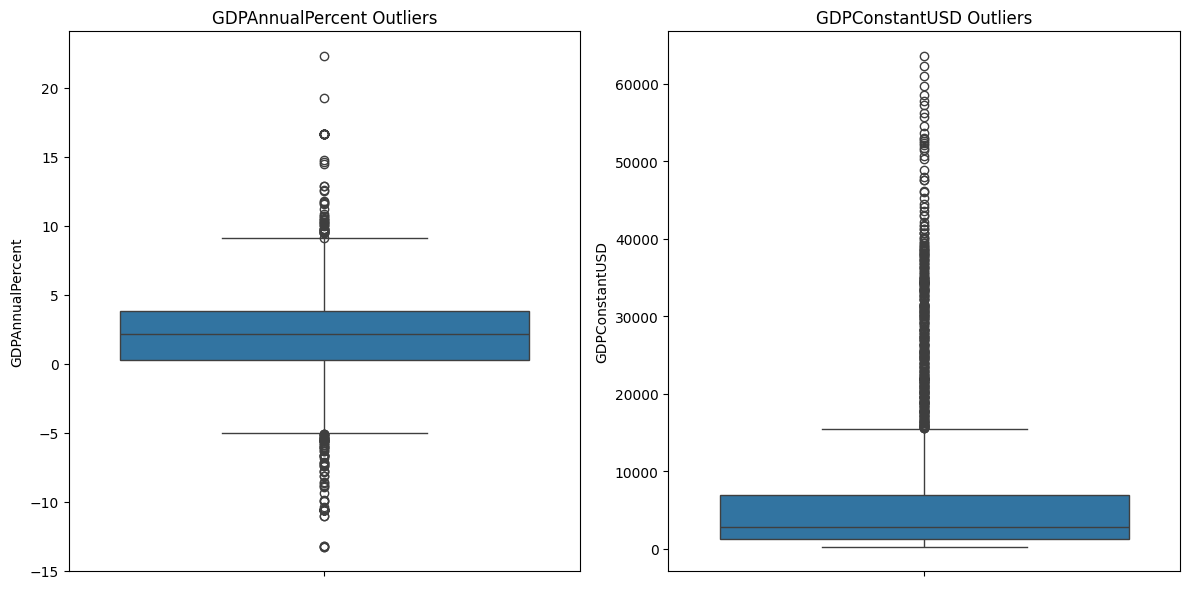

In [22]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

# Boxplot for annual %
sns.boxplot(y=gdp_by_groups["GDPAnnualPercent"], ax=axes[0])
axes[0].set_title("GDPAnnualPercent Outliers")

# Boxplot for constant USD
sns.boxplot(y=gdp_by_groups["GDPConstantUSD"], ax=axes[1])
axes[1].set_title("GDPConstantUSD Outliers")

plt.tight_layout()
plt.show()

#### Comments
**GDPAnnualPercent** suggests natural variable with some extreme outliers. We will use IQR filtering to verify extreme outliers.

**GDPConstantUSD** data is heavily skewed. Transformation will be necessary for an accurate analysis.

#### GDPAnnualPercent IQR Filtering
There are significant outliers found with IQR filtering.

In [23]:
# Identify extreme outliers by IQR
Q1 = gdp_by_groups["GDPAnnualPercent"].quantile(0.25)
Q3 = gdp_by_groups["GDPAnnualPercent"].quantile(0.75)
IQR = Q3 - Q1

outliers_gdp = gdp_by_groups[
    (gdp_by_groups["GDPAnnualPercent"] < Q1 - 1.5 * IQR) |
    (gdp_by_groups["GDPAnnualPercent"] > Q3 + 1.5 * IQR)
]
print(outliers_gdp.count())

Country Code          158
Region Group Name     158
Year                  158
GDPAnnualPercent      158
GDPConstantUSD        158
GDPAnnualPercent_Z    158
GDPConstantUSD_Z      158
dtype: int64


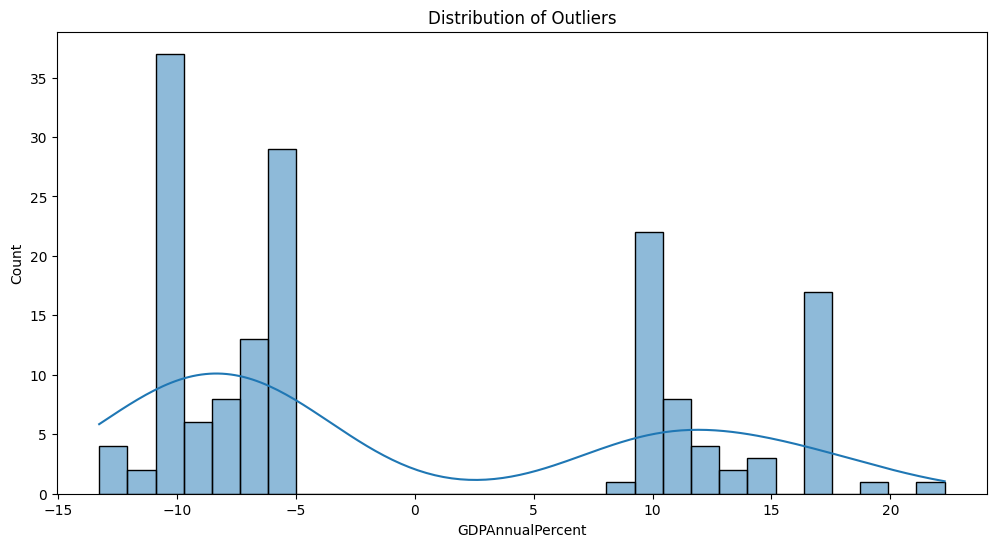

In [24]:
# Visualize distribution of outliers
plt.figure(figsize=(12,6))
sns.histplot(outliers_gdp["GDPAnnualPercent"], bins=30, kde=True)

plt.title("Distribution of Outliers")
plt.show()

In [25]:
# Check sources of outliers
print(outliers_gdp["Region Group Name"].value_counts())

Region Group Name
Central Europe and the Baltics                        32
Other small states                                    21
East Asia & Pacific (excluding high income)            9
Fragile and conflict affected situations               8
East Asia & Pacific (IDA & IBRD)                       8
Middle East & North Africa (IDA & IBRD)                8
Middle East & North Africa (excluding high income)     8
Arab World                                             7
Middle East & North Africa                             7
Africa Western and Central                             6
Pre-demographic dividend                               5
Caribbean small states                                 5
IDA blend                                              5
Small states                                           4
Pacific island small states                            3
Europe & Central Asia (excluding high income)          3
Europe & Central Asia (IDA & IBRD)                     3
Low income   

#### Comments
* High outliers in **Central Europe and the Baltics** which have undergone significant economic transitions historically, which can explain the large swings in GDP.
* **Other small states** and **Fragile and conflict-affected situations** tend to be more susceptible to sudden changes such as conflict, climate events or trade disruptions.
* **Middle East and North Africa** groups can be very susceptible to oil price volatility, which results in boom-and-bust cycles.

**Given economic explanations for extreme swings in GDP**, we will not consider these extreme outliers as errors and remove them, but rather Winzorize them to avoid distorting the analysis.

#### Winsorize Extremes
This prevents extreme values from skewing trends, while still preserving the data.

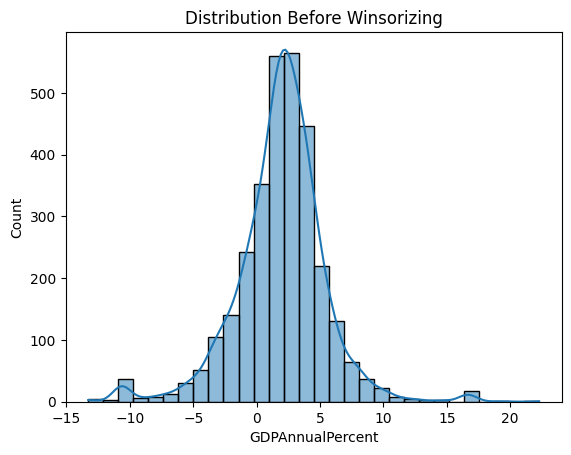

In [26]:
# Visualize distribution of GDPAnnualPercent before Winsorizing
sns.histplot(gdp_by_groups["GDPAnnualPercent"], bins=30, kde=True)
plt.title("Distribution Before Winsorizing")
plt.show()

In [27]:
gdp_by_groups["GDPAnnualPercent_winsorized"] = np.clip(
    gdp_by_groups["GDPAnnualPercent"], -12, 12
)

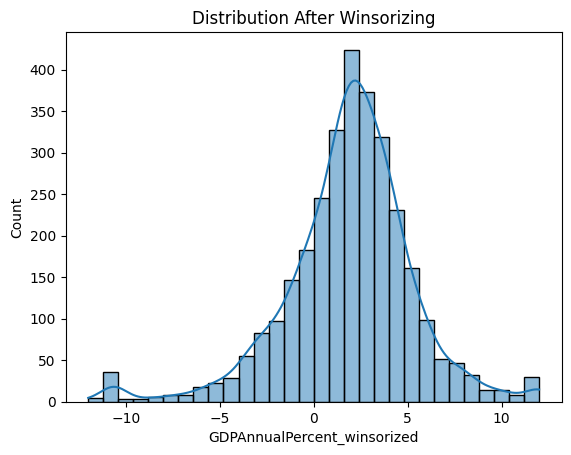

In [28]:
# Visually verify changes
sns.histplot(gdp_by_groups["GDPAnnualPercent_winsorized"], bins=30, kde=True)
plt.title("Distribution After Winsorizing")
plt.show()

In [29]:
# Confirm no extreme outliers are left
gdp_by_groups.describe()

,Year,GDPAnnualPercent,GDPConstantUSD,GDPAnnualPercent_Z,GDPConstantUSD_Z,GDPAnnualPercent_winsorized
count,3072.000000,3072.000000,3072.000000,3.072000e+03,3.072000e+03,3072.000000
mean,1991.500000,1.915004,6642.774408,-2.775558e-17,-1.850372e-17,1.881709
std,18.475961,3.554818,9493.820156,1.000163e+00,1.000163e+00,3.420920
min,1960.000000,-13.286964,274.595307,-4.277136e+00,-6.708802e-01,-12.000000
25%,1975.750000,0.243514,1249.953273,-4.702806e-01,-5.681274e-01,0.243514
50%,1991.500000,2.109874,2888.854832,5.482750e-02,-3.954710e-01,2.109874
75%,2007.250000,3.788082,6977.519630,5.269984e-01,3.526502e-02,3.788082
max,2023.000000,22.285694,63594.398681,5.731378e+00,5.999787e+00,12.000000


### Handle GDPConstantUSD Outliers
Data is heavily skewed and transformation is needed for an accurate analysis. We will test Winsorizing and og transformation for this metric to find the best fit.

In [30]:
# Set quantiles for Winsorizing (caps extreme values)
Q1 = gdp_by_groups["GDPConstantUSD"].quantile(0.25)
Q3 = gdp_by_groups["GDPConstantUSD"].quantile(0.75)
IQR = Q3 - Q1

gdp_by_groups["GDPConstantUSD_winsorized"] = np.clip(
    gdp_by_groups["GDPConstantUSD"], -10, 10
)

# Log transformation (compresses extreme values)
gdp_by_groups["GDPConstantUSD_log"] = np.log1p(gdp_by_groups["GDPConstantUSD"])

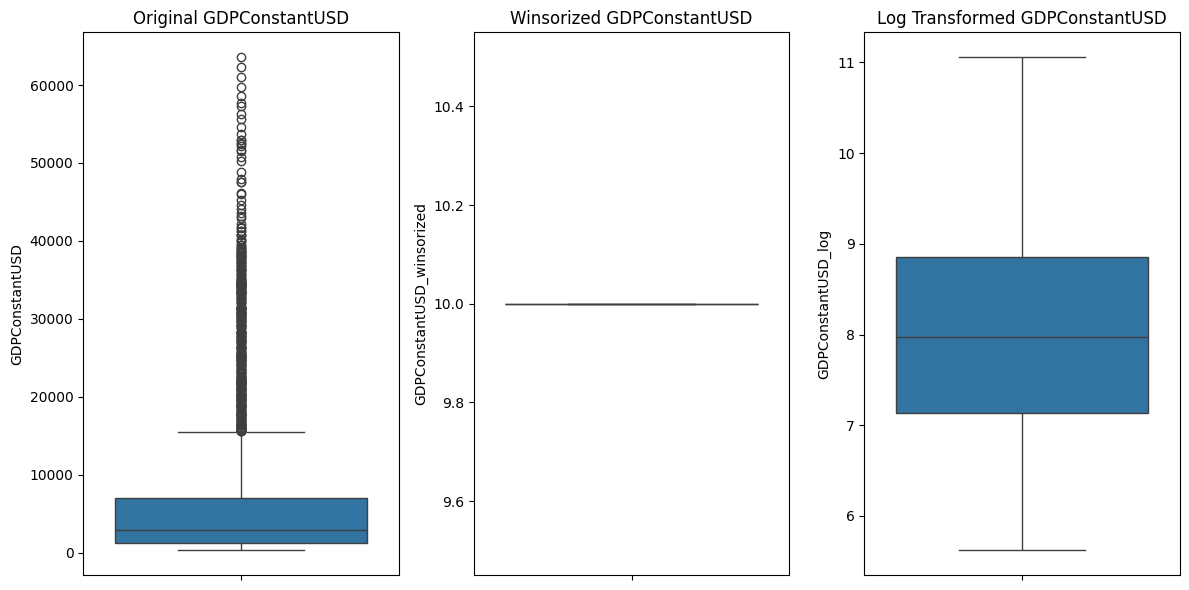

In [31]:
# Compare Distributions
fig, axes = plt.subplots(1,3, figsize=(12,6))

# Original Boxplot for GDPConstantUSD
sns.boxplot(y=gdp_by_groups["GDPConstantUSD"], ax=axes[0])
axes[0].set_title("Original GDPConstantUSD")

# Boxplot for Winsorized GDPConstantUSD
sns.boxplot(y=gdp_by_groups["GDPConstantUSD_winsorized"], ax=axes[1])
axes[1].set_title("Winsorized GDPConstantUSD")

# Boxplot for Log Transformed GDPConstantUSD
sns.boxplot(y=gdp_by_groups["GDPConstantUSD_log"], ax=axes[2])
axes[2].set_title("Log Transformed GDPConstantUSD")

plt.tight_layout()
plt.show()

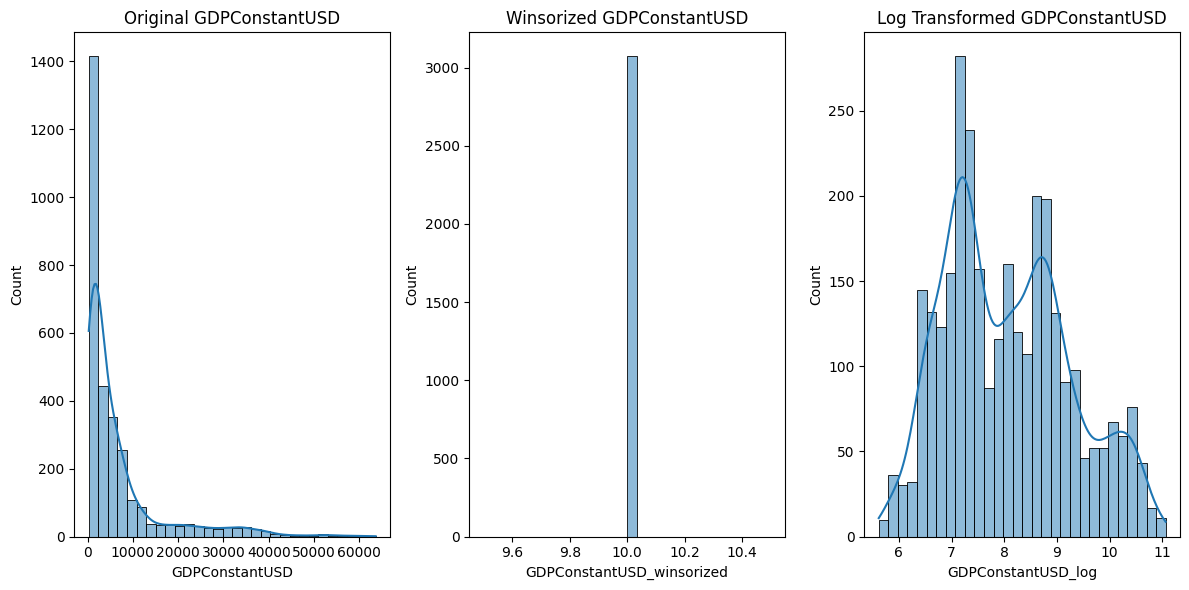

In [32]:
# Compare with histograms
fig, axes = plt.subplots(1,3, figsize=(12,6))

# Original Boxplot for GDPConstantUSD
sns.histplot(gdp_by_groups["GDPConstantUSD"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Original GDPConstantUSD")

# Boxplot for Winsorized GDPConstantUSD
sns.histplot(gdp_by_groups["GDPConstantUSD_winsorized"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Winsorized GDPConstantUSD")

# Boxplot for Log Transformed GDPConstantUSD
sns.histplot(gdp_by_groups["GDPConstantUSD_log"], bins=30, kde=True, ax=axes[2])
axes[2].set_title("Log Transformed GDPConstantUSD")

plt.tight_layout()
plt.show()

#### Log Transformation on GDPConstantUSD
This transformation is most effective for standardizing the extremes of the data.

In [33]:
gdp_by_groups.describe()

,Year,GDPAnnualPercent,GDPConstantUSD,GDPAnnualPercent_Z,GDPConstantUSD_Z,GDPAnnualPercent_winsorized,GDPConstantUSD_winsorized,GDPConstantUSD_log
count,3072.000000,3072.000000,3072.000000,3.072000e+03,3.072000e+03,3072.000000,3072.0,3072.000000
mean,1991.500000,1.915004,6642.774408,-2.775558e-17,-1.850372e-17,1.881709,10.0,8.065750
std,18.475961,3.554818,9493.820156,1.000163e+00,1.000163e+00,3.420920,0.0,1.189501
min,1960.000000,-13.286964,274.595307,-4.277136e+00,-6.708802e-01,-12.000000,10.0,5.618934
25%,1975.750000,0.243514,1249.953273,-4.702806e-01,-5.681274e-01,0.243514,10.0,7.131661
50%,1991.500000,2.109874,2888.854832,5.482750e-02,-3.954710e-01,2.109874,10.0,7.968961
75%,2007.250000,3.788082,6977.519630,5.269984e-01,3.526502e-02,3.788082,10.0,8.850592
max,2023.000000,22.285694,63594.398681,5.731378e+00,5.999787e+00,12.000000,10.0,11.060296


#### Select Final Columns

In [34]:
gdp_by_groups.columns

Index(['Country Code', 'Region Group Name', 'Year', 'GDPAnnualPercent',
       'GDPConstantUSD', 'GDPAnnualPercent_Z', 'GDPConstantUSD_Z',
       'GDPAnnualPercent_winsorized', 'GDPConstantUSD_winsorized',
       'GDPConstantUSD_log'],
      dtype='object')

In [35]:
gdp_by_groups_transformed = gdp_by_groups[['Country Code', 
                                            'Region Group Name', 
                                            'Year', 
                                            'GDPAnnualPercent',
                                            'GDPAnnualPercent_winsorized',
                                            'GDPConstantUSD',
                                            'GDPConstantUSD_log']]

gdp_by_groups_transformed.head(3)

,Country Code,Region Group Name,Year,GDPAnnualPercent,GDPAnnualPercent_winsorized,GDPConstantUSD,GDPConstantUSD_log
0,AFE,Africa Eastern and Southern,1960,-2.136630,-2.136630,1172.316285,7.067589
1,AFE,Africa Eastern and Southern,1961,-2.136630,-2.136630,1147.268217,7.046010
2,AFE,Africa Eastern and Southern,1962,5.009835,5.009835,1204.744460,7.094852


---

## GDP by Country Dataset
### Missing Data

In [36]:
gdp_by_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13952 entries, 0 to 13951
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country Name      13952 non-null  object 
 1   Country Code      13952 non-null  object 
 2   Year              13952 non-null  int64  
 3   GDPAnnualPercent  10999 non-null  float64
 4   GDPConstantUSD    11076 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 545.1+ KB


In [37]:
# Missing data found - check how many exactly
missing_values = gdp_by_country.isnull().sum()
print(missing_values)

Country Name           0
Country Code           0
Year                   0
GDPAnnualPercent    2953
GDPConstantUSD      2876
dtype: int64


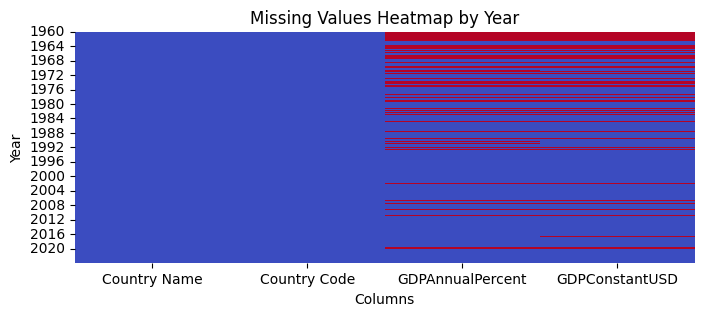

In [38]:
# Set 'Year' as index for correct y-axis labeling
gdp_by_country_by_year = gdp_by_country.sort_values("Year").set_index("Year")

# Plot missing values heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(gdp_by_country_by_year.isna(), cmap="coolwarm", cbar=False)

plt.title("Missing Values Heatmap by Year")
plt.xlabel("Columns")
plt.ylabel("Year")
plt.show()

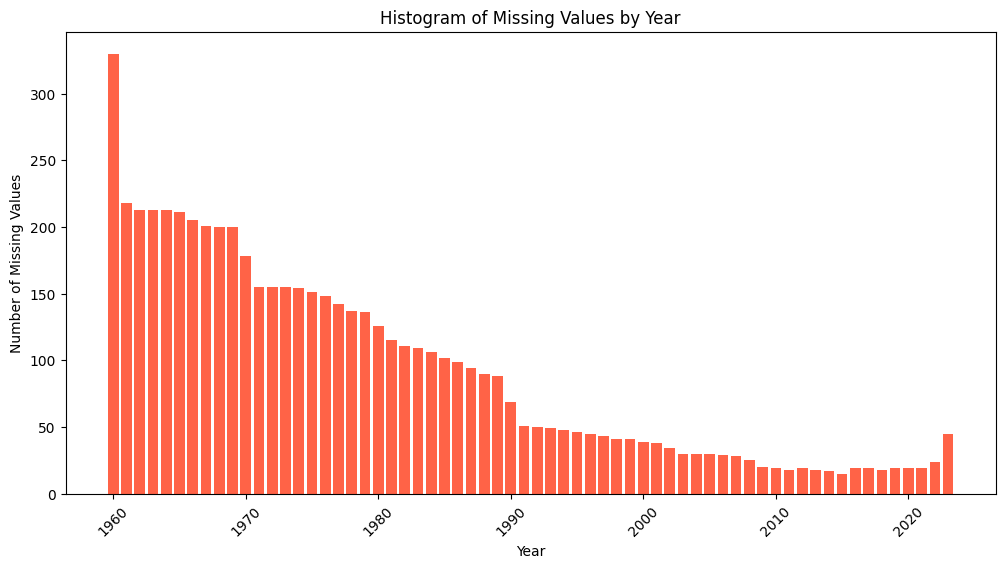

In [39]:
import matplotlib.pyplot as plt

# Count missing values per year
missing_years = gdp_by_country.groupby("Year").apply(lambda x: x.isna().sum().sum())

# Plot histogram
plt.figure(figsize=(12,6))
plt.bar(missing_years.index, missing_years.values, color="tomato")

plt.title("Histogram of Missing Values by Year")
plt.xlabel("Year")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.show()


#### Handling Missing Data
Data gets increasingly more sparse before 1990. We will use forward-filling to fill in the gaps.

In [40]:
# 1960 has very little data. Let's remove it.
gdp_by_country = gdp_by_country[gdp_by_country["Year"] != 1960]

# Apply forward fill to fill in the gaps
gdp_by_country[["GDPAnnualPercent", "GDPConstantUSD"]] = gdp_by_country.groupby("Country Code")[["GDPAnnualPercent", "GDPConstantUSD"]].ffill()

# Apply backward fill to fill in the remaining gaps
gdp_by_country[["GDPAnnualPercent", "GDPConstantUSD"]] = gdp_by_country.groupby("Country Code")[["GDPAnnualPercent", "GDPConstantUSD"]].bfill()

# Check remaining missing values
print(gdp_by_country.isna().sum())

Country Name          0
Country Code          0
Year                  0
GDPAnnualPercent    252
GDPConstantUSD      378
dtype: int64


In [41]:
# Since the remaining gaps are few, we will use median fill
#   to handle the remaining missing values
gdp_by_country["GDPAnnualPercent"].fillna(gdp_by_country["GDPAnnualPercent"].median(), inplace=True)
gdp_by_country["GDPConstantUSD"].fillna(gdp_by_country["GDPConstantUSD"].median(), inplace=True)

# Check remaining missing values
print(gdp_by_country.isna().sum())

Country Name        0
Country Code        0
Year                0
GDPAnnualPercent    0
GDPConstantUSD      0
dtype: int64


#### Duplicated Data
No duplicate data found.

In [42]:
duplicates = gdp_by_country[gdp_by_country.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Country Name, Country Code, Year, GDPAnnualPercent, GDPConstantUSD]
Index: []


### Outliers
The data summary suggests the presence of outliers in both data columns, with extreme values seen at the min and max values. Transformation will be necessary for accurate analysis.

In [43]:
gdp_by_country.describe()

,Year,GDPAnnualPercent,GDPConstantUSD
count,13734.000000,13734.000000,13734.000000
mean,1992.000000,1.408754,13252.025703
std,18.184904,6.894811,21985.247985
min,1961.000000,-64.423582,122.678901
25%,1976.000000,-0.892925,1484.736154
50%,1992.000000,1.962206,3957.383586
75%,2008.000000,4.454688,16426.461326
max,2023.000000,140.490578,224582.449752


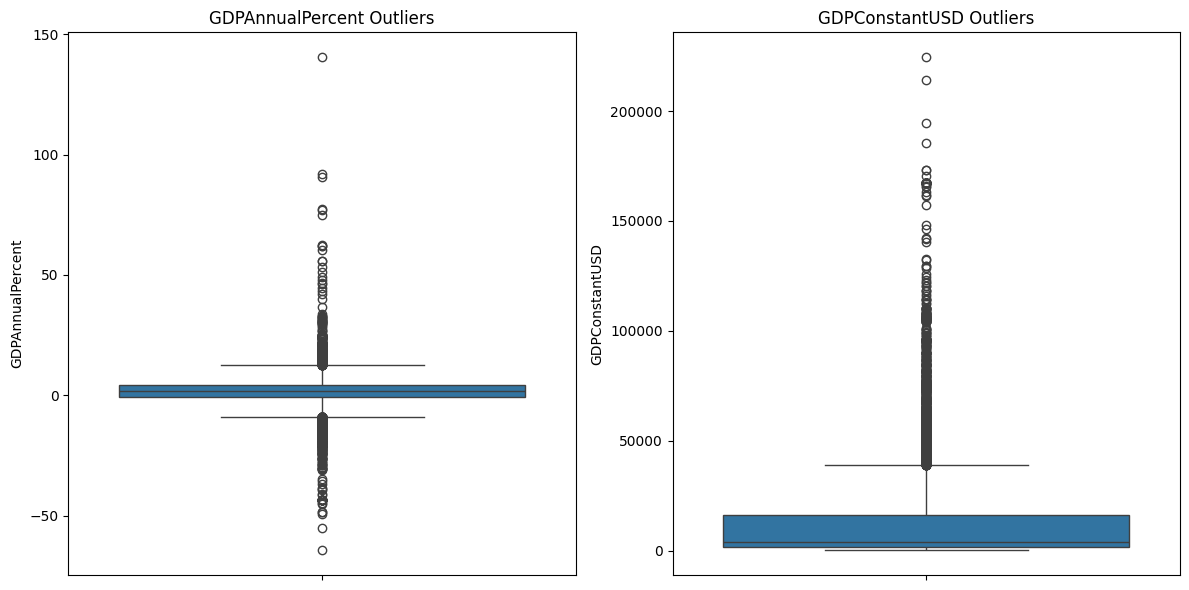

In [44]:
# Confirm outliers visually
fig, axes = plt.subplots(1,2, figsize=(12,6))

# Boxplot for annual %
sns.boxplot(y=gdp_by_country["GDPAnnualPercent"], ax=axes[0])
axes[0].set_title("GDPAnnualPercent Outliers")

# Boxplot for constant USD
sns.boxplot(y=gdp_by_country["GDPConstantUSD"], ax=axes[1])
axes[1].set_title("GDPConstantUSD Outliers")

plt.tight_layout()
plt.show()

#### Comments
**GDPAnnualPercent** show that normal GDP fluctations are minor, but there are many outliers both above and below 0, indicating frequent extreme changes in annual GDP growth.

**GDPConstantUSD** shows that most economies have relatively small GDP figures, and large economies heavily influence the spread.

#### Winsorize Extremes of GDPAnnualPercent
This will smooth GDPAnnualPercent to limit extreme fluctuations.

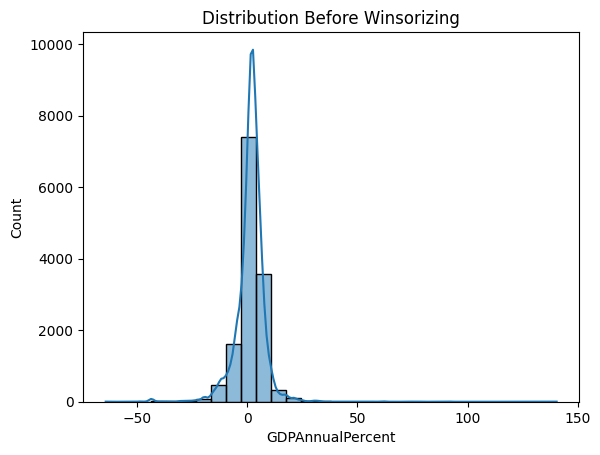

In [45]:
# Visualize distribution of GDPAnnualPercent before Winsorizing
sns.histplot(gdp_by_country["GDPAnnualPercent"], bins=30, kde=True)
plt.title("Distribution Before Winsorizing")
plt.show()

In [46]:
# Winsorize (cap extreme limits)
gdp_by_country["GDPAnnualPercent_winsorized"] = np.clip(
    gdp_by_country["GDPAnnualPercent"], -10, 10
)

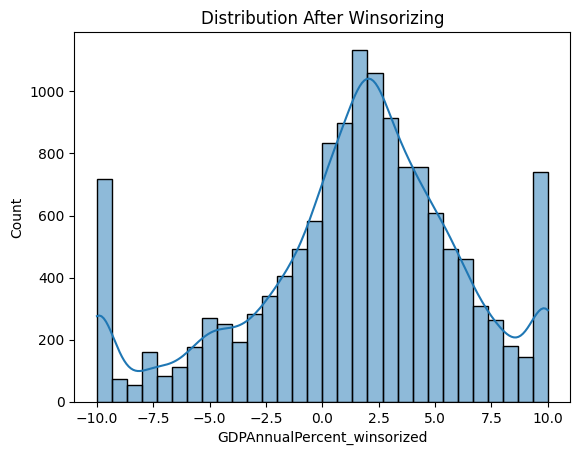

In [47]:
# Visually verify changes
sns.histplot(gdp_by_country["GDPAnnualPercent_winsorized"], bins=30, kde=True)
plt.title("Distribution After Winsorizing")
plt.show()

#### Comments
The Winsorized data is almost standard, but has spikes at either extreme. To smooth this out a little bit more, we will adjust the Winsorizing threshold.

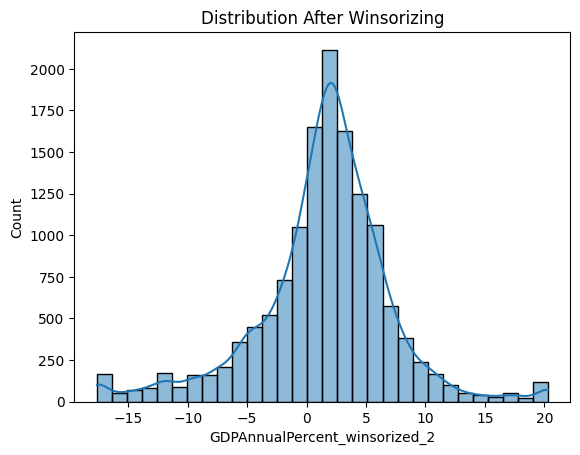

In [48]:
Q1 = gdp_by_country["GDPAnnualPercent"].quantile(0.15)  # Lower threshold
Q3 = gdp_by_country["GDPAnnualPercent"].quantile(0.85)  # Upper threshold
IQR = Q3 - Q1

gdp_by_country["GDPAnnualPercent_winsorized_2"] = np.clip(
    gdp_by_country["GDPAnnualPercent"], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
)

# Visually verify changes
sns.histplot(gdp_by_country["GDPAnnualPercent_winsorized_2"], bins=30, kde=True)
plt.title("Distribution After Winsorizing")
plt.show()

#### Log Transformation on GDPConstantUSD
The log transformation will be the most effective for highly skewed data by compressing large values while maintaining the economic growth patterns.

In [49]:
# Apply log transformation
gdp_by_country["GDPConstantUSD_log"] = np.log1p(gdp_by_country["GDPConstantUSD"])

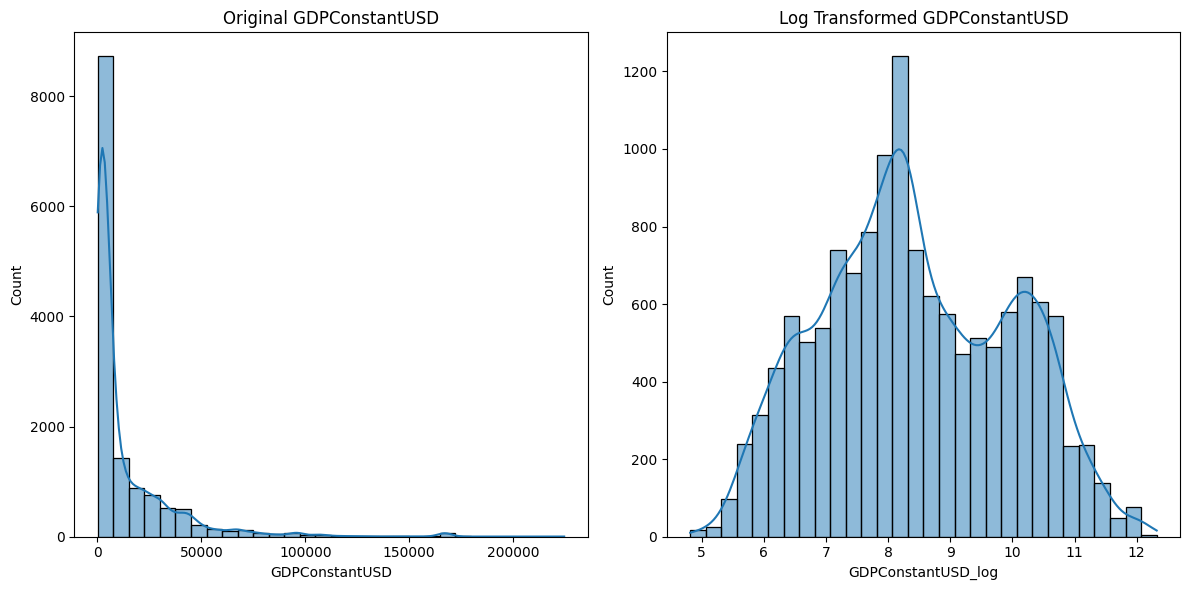

In [50]:
# Compare the orginial with the transformed data side-by-side
# Compare with histograms
fig, axes = plt.subplots(1,2, figsize=(12,6))

# Original Boxplot for GDPConstantUSD
sns.histplot(gdp_by_country["GDPConstantUSD"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Original GDPConstantUSD")

# Boxplot for Log Transformed GDPConstantUSD
sns.histplot(gdp_by_country["GDPConstantUSD_log"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Log Transformed GDPConstantUSD")

plt.tight_layout()
plt.show()

In [51]:
gdp_by_country.describe()

,Year,GDPAnnualPercent,GDPConstantUSD,GDPAnnualPercent_winsorized,GDPAnnualPercent_winsorized_2,GDPConstantUSD_log
count,13734.000000,13734.000000,13734.000000,13734.000000,13734.000000,13734.000000
mean,1992.000000,1.408754,13252.025703,1.422219,1.430708,8.439029
std,18.184904,6.894811,21985.247985,4.799090,5.747436,1.510513
min,1961.000000,-64.423582,122.678901,-10.000000,-17.643616,4.817689
25%,1976.000000,-0.892925,1484.736154,-0.892925,-0.892925,7.303666
50%,1992.000000,1.962206,3957.383586,1.962206,1.962206,8.283591
75%,2008.000000,4.454688,16426.461326,4.454688,4.454688,9.706710
max,2023.000000,140.490578,224582.449752,10.000000,20.298040,12.322003


#### Select Final Columns

In [52]:
gdp_by_country.columns

Index(['Country Name', 'Country Code', 'Year', 'GDPAnnualPercent',
       'GDPConstantUSD', 'GDPAnnualPercent_winsorized',
       'GDPAnnualPercent_winsorized_2', 'GDPConstantUSD_log'],
      dtype='object')

In [53]:
gdp_by_country_transformed = gdp_by_country[['Country Code', 
                                    'Country Name', 
                                    'Year', 
                                    'GDPConstantUSD',
                                    'GDPConstantUSD_log',
                                    'GDPAnnualPercent',
                                    'GDPAnnualPercent_winsorized_2']]
gdp_by_country_transformed.rename(columns={
    "GDPAnnualPercent_winsorized_2": "GDPAnnualPercent_winsorized"
    }, inplace=True)

gdp_by_country_transformed.head(3)

,Country Code,Country Name,Year,GDPConstantUSD,GDPConstantUSD_log,GDPAnnualPercent,GDPAnnualPercent_winsorized
1,AFG,Afghanistan,1961,308.31827,5.734371,-10.119484,-10.119484
2,AFG,Afghanistan,1962,308.31827,5.734371,-10.119484,-10.119484
3,AFG,Afghanistan,1963,308.31827,5.734371,-10.119484,-10.119484


## Export Datasets

In [ ]:
# Countries cleaned
# countries.to_csv("../data/in_process/2a_countries_cleaned.csv")

# Regions/Groups cleaned
# region_groups.to_csv("../data/in_process/2a_region_groups_cleaned.csv")

# Regions/Groups cleaned
# gdp_by_groups_transformed.to_csv("../data/in_process/2a_gdp_by_groups_cleaned.csv")

# Countries cleaned
# gdp_by_country_transformed.to_csv("../data/in_process/2a_gdp_by_country_cleaned.csv")